This is a version of object detection that goes through the thought process more in depth.

##### Step 1. Loading the Input image/s

In [41]:
# import dependencies 
import os 
os.environ ['KMP_DUPLICATE_LIB_OK'] = 'True'
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# SAM/OpenCLIP dependencies
import torch
import torchvision
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import Image

# COCO dependencies
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

Loading input image using COCO

In [6]:
# Loading COCO
dataDir='..'
dataType='val2017'
annFile='{}/coco/annotations/instances_{}.json'.format(dataDir,dataType)

# initialize COCO api for instance annotations
coco=COCO(annFile)

In [10]:
# randomly sample an image from COCO Val split 2017
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person','dog','skateboard']);
imgIds = coco.getImgIds(catIds=catIds );
imgIds = coco.getImgIds(imgIds = [324158])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

In [34]:
# display COCO categories and store them into array 'labels'
cats = coco.loadCats(coco.getCatIds())
labels = [cat['name'] for cat in cats]
print(labels)

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


<class 'PIL.Image.Image'>
<class 'numpy.ndarray'>


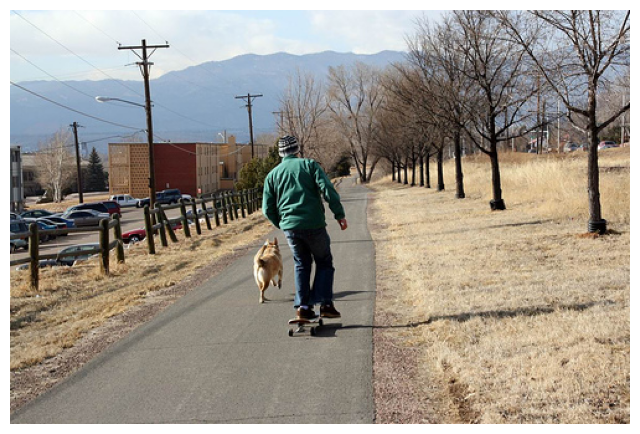

In [57]:
# load and display image
image = io.imread(img['coco_url'])
im  = Image.fromarray(image)
print(type(im))
print(type(image))
plt.axis('off')
plt.imshow(image)
plt.show()

Loading input image locally using image upload

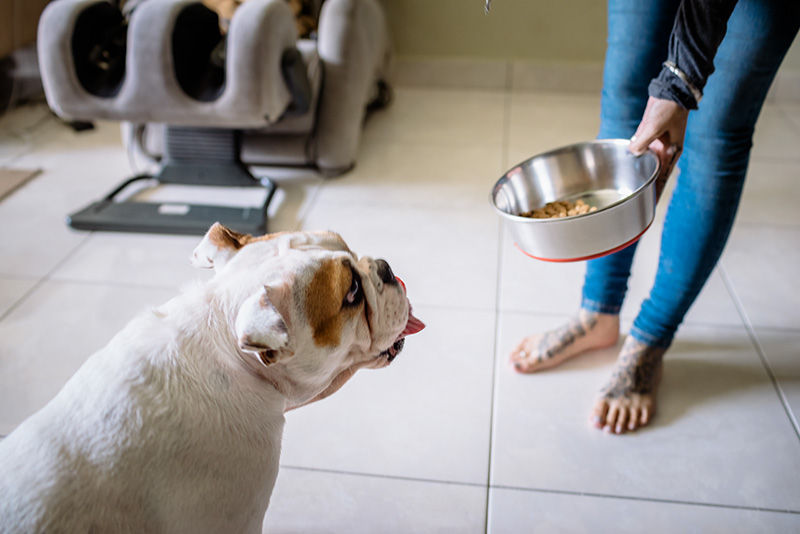

In [4]:
# Our Input: Image
Image('images/dog.jpg') # edit this to try out different images

##### Step 2. Segment Anything Output

In [12]:
# Loading SAM Model
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "../sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# Loading SAM Predictor
mask_generator = SamAutomaticMaskGenerator(sam)

In [36]:
# Get the masks for the COCO generated image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [88]:
# Get the masks for the locally generated image
image = cv2.imread('images/dog.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [89]:
# Run automatic mask generation
im = Image.open("images/dog.jpg")

masks = mask_generator.generate(image)

In [29]:
# Loading OpenCLIP
import torch
from PIL import Image
import open_clip

model, _, transform = open_clip.create_model_and_transforms(
  model_name="coca_ViT-L-14",
  pretrained="mscoco_finetuned_laion2B-s13B-b90k"
)

argmax:  dog
top_labels:
1.  dog :  0.9790651798248291 
2.  cow :  0.017583686858415604


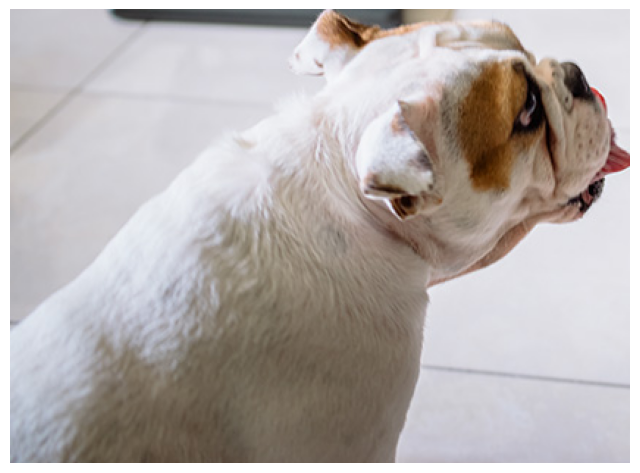

argmax:  dog
top_labels:
1.  dog :  0.9092226028442383 
2.  bowl :  0.06633765995502472


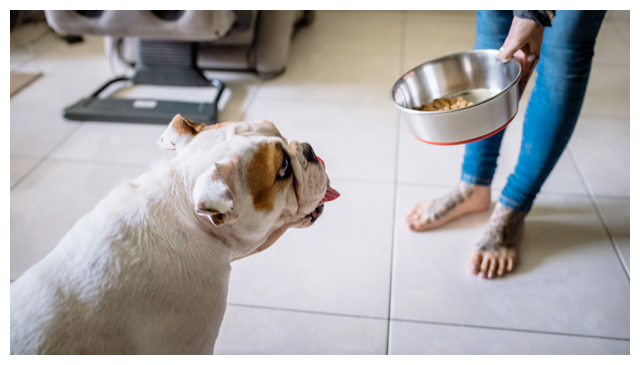

KeyboardInterrupt: 

In [96]:
# Tokenize the labels
labels_tokenized = open_clip.tokenize(["This is " + desc for desc in labels])

# Run through all the masks and then crop image to ask OpenClip "This is a photo of what?"
length_masks = len(masks)
for mask in range(length_masks): 
    # crop the image AKA get the bounding box
    bbox_xywh = masks[mask]['bbox'] # the SAM model returns the bounding box in xywh format
    bbox_lurd = [bbox_xywh[0], bbox_xywh[1], bbox_xywh[0] + bbox_xywh[2], 
    bbox_xywh[1] + bbox_xywh[3]] # convert the bounding box to LURD format
    cropped_image = im.crop(bbox_lurd) # Crop the image using the bounding box coordinates
    display_image = cropped_image.convert("RGB")
    cropped_image = transform(display_image).unsqueeze(0)
    
    # ask OpenClip "This is a photo of what?"
    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(cropped_image).float()
        text_features = model.encode_text(labels_tokenized).float()
    
    # Normalize the features and calculate the dot product of each pair.
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
    
    # Get the predicted label
    predicted_label_index = similarity.argmax()
    predicted_label = labels[predicted_label_index]
    
    # get the top 2 probabilities and labels
    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    top_probs, top_labels = text_probs.cpu().topk(2, dim=-1)
    
    print("predicted label: ", predicted_label)
    print("top_labels:\n1. ", labels[top_labels[0][0].item()], ": ", top_probs[0][0].item(),
          "\n2. ", labels[top_labels[0][1].item()], ": ", top_probs[0][1].item())
    
    plt.axis('off')
    plt.imshow(display_image)
    plt.show()

In [92]:
bbox_xywh = masks[1]['bbox']
print(bbox_xywh)

# Convert the bounding box to LURD format
bbox_lurd = [bbox_xywh[0], bbox_xywh[1], bbox_xywh[0] + bbox_xywh[2],bbox_xywh[1] + bbox_xywh[3]]
print(bbox_lurd)

[0, 87, 799, 445]
[0, 87, 799, 532]


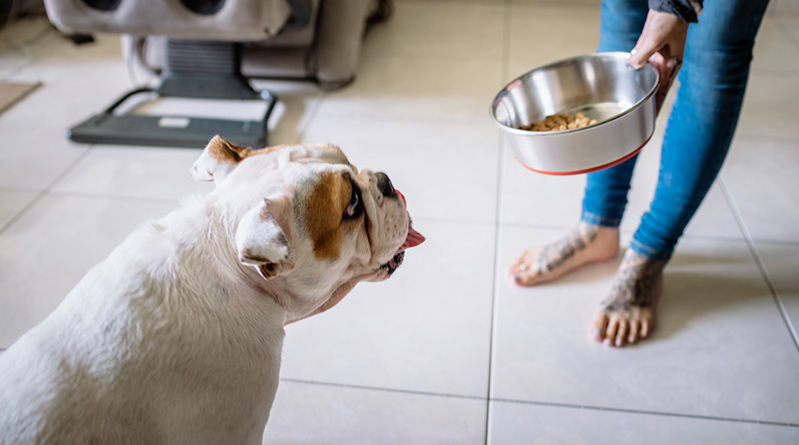

In [93]:
cropped_image = im.crop(bbox_lurd) # Crop the image using the bounding box coordinates
cropped_image.convert("RGB")


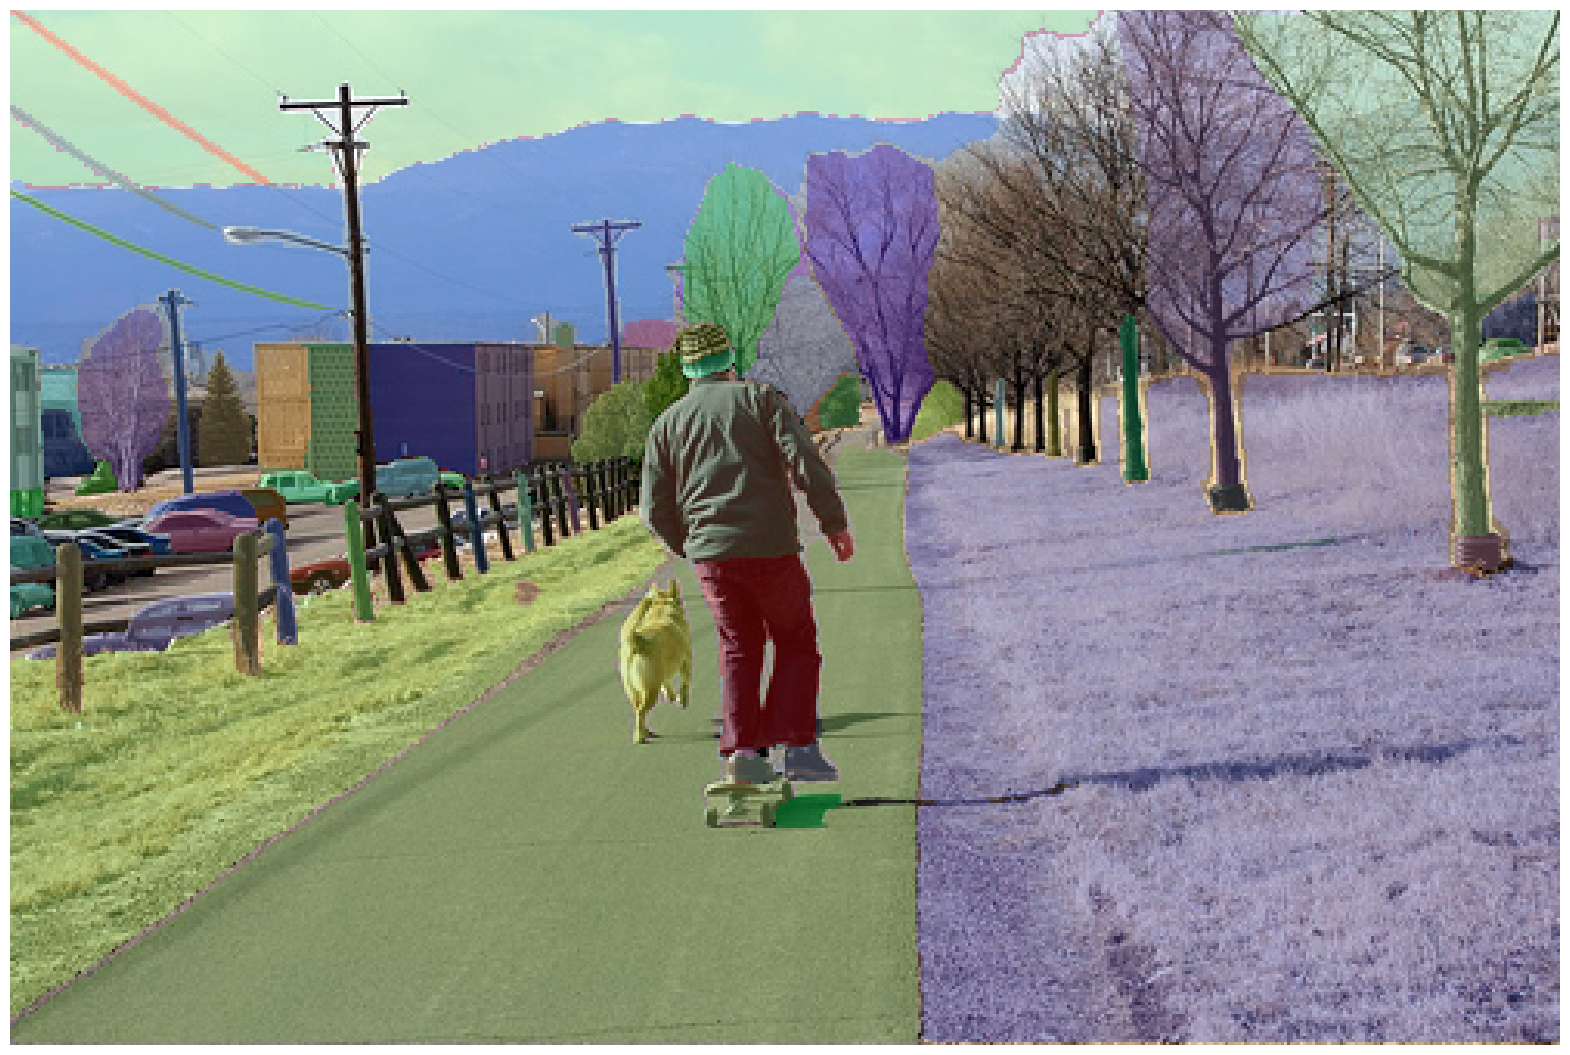

In [59]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)
    
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

Step 3. Crop images for each mask

Step 4. Use CLIP to label the mask : clip_label

Step 5. Compare clip_label to COCO

In [ ]:
# If clip_label in COCO: Compare the prediction with ground truth Score using mAP -> get ground score
# Else: Ignore